In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold
from features import *

from report import *
import operator
from tqdm import tqdm
import seaborn as sns
import pprint as pp
from itertools import combinations

from tools import drop_cols
from tools import print_corr
from tools import compare_corr
from tools import dict_to_sortedlist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load pickle

In [10]:
%%time
df_train = pd.read_pickle("input/train_lv01.pickle")
df_test = pd.read_pickle("input/test_lv01.pickle")

train_size = df_train.shape[0]
target_col = 'totals_transactionRevenue'
df_train[target_col].fillna(0.0, inplace=True)
df_train[target_col] = df_train[target_col].astype(float)


# Drop cols nunique < 2
del_cols = ['totals_bounces', 'totals_newVisits', 'visitId']
df_train = drop_cols(df_train, del_cols)
df_test = drop_cols(df_test, del_cols)

CPU times: user 6.92 s, sys: 1.67 s, total: 8.6 s
Wall time: 7.37 s


#### Corr df_train

In [ ]:
_ = print_corr(df_train.corr())

In [ ]:
_ = print_corr(df_train[df_train[target_col] > 0].corr())

In [ ]:
_ = print_corr(df_train[df_train[target_col] == 0].corr())

#### Corr df_test

In [ ]:
_ = print_corr(df_test.corr())

### Feature Engineering

In [11]:
%%time
df_train = fea_remap(df_train)
df_test = fea_remap(df_test)

'fea_remap'  2045.75 ms
'fea_remap'  1796.19 ms
CPU times: user 3.73 s, sys: 107 ms, total: 3.84 s
Wall time: 3.84 s


In [12]:
%%time
df_train, fea_cols = get_features(df_train)
df_test, fea_cols = get_features(df_test)
df_train[target_col] = np.log1p(df_train[target_col])

'fea_date_time'  20634.98 ms
'fea_format'  110.05 ms
'fea_device'  2226.09 ms
'fea_totals'  2049.54 ms
'fea_geo_network'  471.85 ms
'fea_traffic_source'  2424.74 ms
'fea_shift'  5477.48 ms
'fea_date_time'  17254.46 ms
'fea_format'  92.74 ms
'fea_device'  1987.07 ms
'fea_totals'  1805.72 ms
'fea_geo_network'  374.37 ms
'fea_traffic_source'  2167.88 ms
'fea_shift'  4540.44 ms
CPU times: user 1min 32s, sys: 11.3 s, total: 1min 43s
Wall time: 1min 1s


In [13]:
%%time
df_train = fea2_groupby(df_train)
df_test = fea2_groupby(df_test)

In [14]:
%%time
df_train = fea2_comb(df_train)
df_test = fea2_comb(df_test)

'fea2_comb'  6706.42 ms
'fea2_comb'  5807.92 ms


#### corr df_train and df_test

In [ ]:
# _ = print_corr(df_train.corr())

In [ ]:
# _ = print_corr(df_test.corr())

#### ttest between df_train and df_test

In [ ]:
# from scipy.stats import ttest_ind
# c = 'browser_category'
# print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

# for c in fea_cols:
#     print(c, ttest_ind(df_train[c], df_test[c], equal_var=False))

### Encodings

In [15]:
not_used_cols = [
    "date",
    "fullVisitorId",
    "sessionId",
    "visitId",
    'trafficSource_campaignCode',
    target_col,
    #     "visitNumber",
    #     "visitStartTime",
    #     'trafficSource_referralPath',
]

categorical_feature = df_train.select_dtypes(include='object').columns
categorical_feature = [
    c for c in categorical_feature if c not in not_used_cols
]
df_train[categorical_feature].fillna('NA_NULL', inplace=True)
df_test[categorical_feature].fillna('NA_NULL', inplace=True)

len(categorical_feature)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


61

#### Label Encoding

In [16]:
df_train, df_test = encode_label(df_train, df_test, categorical_feature)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'browser_category', 'browser_operatingSystem', 'source_country', 'campaign_medium', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork_city_device_browser', 'geoNetwork_city_device_deviceCategory', 'geoNetwork_city_device_operatingSystem', 'geoNetwork_city_trafficSource_source', 'geo

100%|██████████| 61/61 [02:50<00:00,  1.28s/it]

'encode_label'  192225.35 ms


#### Freq Encoding

In [17]:
df_train, df_test = encode_frequency(df_train, df_test, categorical_feature)

100%|██████████| 61/61 [01:44<00:00,  1.99s/it]

(903653, 161) (804684, 160)
'encode_frequency'  106326.82 ms


#### Mean Encoding

In [18]:
df_train, df_test = encode_mean_k_fold(df_train, df_test, categorical_feature, target_col)

100%|██████████| 61/61 [06:00<00:00,  6.74s/it]

(903653, 222) (804684, 221)
Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem',
       ...
       'mean_k_fold_geoNetwork_region_device_browser',
       'mean_k_fold_geoNetwork_region_device_deviceCategory',
       'mean_k_fold_geoNetwork_region_device_operatingSystem',
       'mean_k_fold_geoNetwork_region_trafficSource_source',
       'mean_k_fold_geoNetwork_subContinent_device_browser',
       'mean_k_fold_geoNetwork_subContinent_device_deviceCategory',
       'mean_k_fold_geoNetwork_subContinent_device_operatingSystem',
       'mean_k_fold_geoNetwork_subContinent_trafficSource_source',
       'mean_k_fold_content_source', 'mean_k_fold_medium_source'],
      dtype='object', length=222)
'encode_mean_k_fold'  360242.39 ms


#### LDA (target_col) : 망함

In [19]:
# y_categorized = np.digitize(df_train[target_col], bins=np.arange(2,24,2))
# clf = LinearDiscriminantAnalysis(n_components=10)
# clf.fit(df_train[categorical_feature], y_categorized)

In [20]:
# df_train_lda = pd.DataFrame(clf.transform(df_train[categorical_feature]))
# df_test_lda = pd.DataFrame(clf.transform(df_test[categorical_feature]))

# col_map={i:'lda_{}'.format(i) for i in range(10)}
# df_train_lda.rename(columns=col_map, inplace=True)
# df_test.rename(columns=col_map, inplace=True)

# df_train = pd.concat([df_train, df_train_lda], axis=1)
# df_test = pd.concat([df_test, df_test_lda], axis=1)                

#### LDA (totals_hits) : good

In [21]:
# y_col = 'totals_hits'
# merged_y = pd.concat([df_train[y_col], df_test[y_col]])
# merged_y.hist()
# y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [22]:
# df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

#### LDA (totals_pageviews) : better

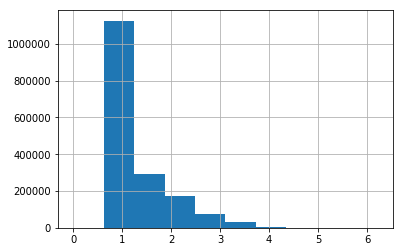

In [23]:
y_col = 'totals_pageviews'
merged_y = pd.concat([df_train[y_col], df_test[y_col]])
merged_y.hist()
y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [24]:
df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, n_components=10, fea_name=y_col)

lda_totals_pageviews_0to9


/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(903653, 227) (804684, 226)
'encode_lda'  16104.55 ms


#### LDA (hits / pageviews) : 망함

In [25]:
# y_col = 'hits_pageviews_rate'
# merged_y = pd.concat([
#     df_train['totals_hits'] / df_train['totals_pageviews'],
#     df_test['totals_hits'] / df_test['totals_pageviews']
# ])
# merged_y[np.isinf(merged_y)] = 0
# merged_y = merged_y * 10
# merged_y.hist()

In [26]:
# bins = np.arange(10,25,1)
# bins = np.insert(bins, 0, 0)
# y_categorized = np.digitize(merged_y, bins=bins)
# np.unique(y_categorized, return_counts=True)

In [27]:
# df_train, df_test = encode_lda(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

#### PCA (totals_hits or totals_pageviews(망)) : 

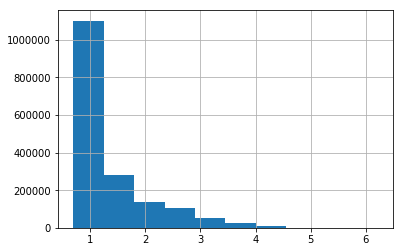

In [28]:
y_col = 'totals_hits'
merged_y = pd.concat([df_train[y_col], df_test[y_col]])
merged_y.hist()
y_categorized = np.digitize(merged_y, bins=np.arange(0,6,1))

In [29]:
df_train, df_test = encode_pca(df_train, df_test, categorical_feature, y_categorized, fea_name=y_col)

pca_totals_hits_0to9
(903653, 237) (804684, 236)
'encode_pca'  15933.68 ms


### Split X and y, Remove not_used_cols

In [30]:
# del_cols = [c for c in df_train.columns if 'lda_totals_pageviews' in c]
# df_train.drop(del_cols, axis=1, inplace=True)
# df_test.drop(del_cols, axis=1, inplace=True)

In [31]:
df_train_y = df_train[target_col].astype(float)

df_train_idx = df_train[['fullVisitorId', target_col]]
df_train_X = drop_cols(df_train.copy(), not_used_cols)

df_test_idx = df_test[['fullVisitorId']]
df_test_X = drop_cols(df_test.copy(), not_used_cols)

In [32]:
# df_train_X.drop(categorical_feature, axis=1, inplace=True)
# df_test_X.drop(categorical_feature, axis=1, inplace=True)

### Training

In [33]:
def modeling(X_train, X_valid, y_train, y_valid, params, model_tag):
    print('X_train:', X_train.shape, 'X_valid:', X_valid.shape, 'Rate:',
          X_valid.shape[0] / X_train.shape[0])
    if X_valid.shape[0] / X_train.shape[0] > 1.0:
        print('No Execution')
        return

    train = lgb.Dataset(
        X_train.values,
        label=y_train.values,
        feature_name=feature_name,
#                         categorical_feature=categorical_feature
    )

    valid = lgb.Dataset(
        X_valid.values,
        label=y_valid.values,
        feature_name=feature_name,
#                         categorical_feature=categorical_feature
    )

    evals_result = {}
    train_params = {
        'params': params,
        'train_set': train,
        'valid_sets': [train, valid],
        'valid_names': ['train', 'valid'],
        'early_stopping_rounds': 300,  #50
        'num_boost_round': 10000,  #500
        'verbose_eval': 25,
        'feval': None,
        'evals_result': evals_result,
        #     'categorical_feature': 'auto',
    }

    model = lgb.train(**train_params)

    global prediction_train, prediction
    print('predict train set')
    pred_train = model.predict(
        df_train_X.values, num_iteration=model.best_iteration)
    prediction_train += pred_train
    df_fold_train = df_train_idx.copy()
    df_fold_train[model_tag] = pred_train

    print('predict test set')
    pred = model.predict(df_test_X.values, num_iteration=model.best_iteration)
    prediction += pred
    df_fold_test = df_test_idx.copy()
    df_fold_test[model_tag] = pred

    # report
    global submit_file_path
    submit_file_path = ''
    msg = [
        model_tag, 
        'model.best_iteration:{}'.format(model.best_iteration),
        str(df_train_X.columns.values), 
        str(train_params)
    ]
    submit_file_path = report(df_fold_train, df_fold_test, pred_train, pred,
                              msg, model)
    print(submit_file_path)

    return model

#### Train 531

In [34]:
feature_name = list(df_train_X.columns)
print(feature_name)
prediction_train = np.zeros(df_train_X.shape[0])
prediction = np.zeros(df_test_X.shape[0])
submit_file_path = ''

#     params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "max_depth": 8,
#         "min_child_samples": 20,
#         "reg_alpha": 1,
#         "reg_lambda": 1,
#         "num_leaves": 257,
#         "learning_rate": 0.01,
#         "subsample": 0.8,
#         "colsample_bytree": 0.8,
#         "subsample_freq ": 5,
#     }
#     params = {
#     "objective": "regression",
#     "metric": "rmse",
#     "num_leaves": 30,
#     "min_child_samples": 100,
#     "learning_rate": 0.1,
#     "bagging_fraction": 0.7,
#     "feature_fraction": 0.5,
#     "bagging_frequency": 5,
#     "bagging_seed": 2018,
#     "verbosity": -1
# }

# param = {
#     "objective": "regression",
#     "metric": "rmse",
#     "max_depth": 8,
#     "min_child_samples": 21,
#     "reg_alpha": 1,
#     "reg_lambda": 1,
#     "num_leaves": 257,
#     "learning_rate": 0.01,
#     "subsample": 0.82,
#     "colsample_bytree": 0.84,
#     "verbosity": -1
# }

params = {
    "boosting_type": 'gbdt',  #'dart', #gbdt',
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 24,  #15 #20 #24 #30
    "min_child_samples": 100,
    "learning_rate": 0.01,  #0.1
    "bagging_fraction": 0.7,
    "feature_fraction": 0.5,
    "bagging_seed": 1989,
    "verbosity": -1,
    'seed': 1989
}

# model_tag = 20170430
model_tag = 20170531
cond = df_train['date'] <= model_tag
X_train, X_valid = df_train_X[cond], df_train_X[~cond]
y_train, y_valid = df_train_y[cond], df_train_y[~cond]

model = modeling(X_train, X_valid, y_train, y_valid, params, str(model_tag))

['channelGrouping', 'visitNumber', 'visitStartTime', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_hits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'month', 'day', 'hour', 'weekday', 'month_unique_user_count', 'weekday_unique_user_count', 'hour_unique_user_count', 'user_hour_mean', 'user_hour_max', 'user_hour_min', 'user_hour_var', 'user_hour_max-min', 'user_weekday_hour_mean', 'browser_category', 'browser_opera

X_train: (765707, 233) X_valid: (137946, 233) Rate: 0.18015507237102443
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.8817	valid's rmse: 2.02615
[50]	train's rmse: 1.82221	valid's rmse: 1.95923
[75]	train's rmse: 1.77319	valid's rmse: 1.90331
[100]	train's rmse: 1.73645	valid's rmse: 1.86186
[125]	train's rmse: 1.70572	valid's rmse: 1.82586
[150]	train's rmse: 1.6835	valid's rmse: 1.80098
[175]	train's rmse: 1.66529	valid's rmse: 1.78046
[200]	train's rmse: 1.65179	valid's rmse: 1.76414
[225]	train's rmse: 1.64101	valid's rmse: 1.75164
[250]	train's rmse: 1.6314	valid's rmse: 1.73998
[275]	train's rmse: 1.62438	valid's rmse: 1.73259
[300]	train's rmse: 1.61805	valid's rmse: 1.72666
[325]	train's rmse: 1.61083	valid's rmse: 1.71958
[350]	train's rmse: 1.60615	valid's rmse: 1.71584
[375]	train's rmse: 1.60142	valid's rmse: 1.71224
[400]	train's rmse: 1.5972	valid's rmse: 1.70903
[425]	train's rmse: 1.59262	valid's rmse: 1.70573
[450]	train's rmse: 1.

[4025]	train's rmse: 1.40179	valid's rmse: 1.67104
[4050]	train's rmse: 1.40106	valid's rmse: 1.67105
[4075]	train's rmse: 1.4004	valid's rmse: 1.67099
[4100]	train's rmse: 1.39965	valid's rmse: 1.671
[4125]	train's rmse: 1.39893	valid's rmse: 1.67097
[4150]	train's rmse: 1.3981	valid's rmse: 1.67103
[4175]	train's rmse: 1.3973	valid's rmse: 1.67101
[4200]	train's rmse: 1.39671	valid's rmse: 1.67104
[4225]	train's rmse: 1.39586	valid's rmse: 1.67099
[4250]	train's rmse: 1.39522	valid's rmse: 1.67099
[4275]	train's rmse: 1.39452	valid's rmse: 1.67098
[4300]	train's rmse: 1.39381	valid's rmse: 1.67102
[4325]	train's rmse: 1.3931	valid's rmse: 1.67102
[4350]	train's rmse: 1.39236	valid's rmse: 1.67101
[4375]	train's rmse: 1.39173	valid's rmse: 1.67095
[4400]	train's rmse: 1.39092	valid's rmse: 1.67091
[4425]	train's rmse: 1.39014	valid's rmse: 1.67088
[4450]	train's rmse: 1.38942	valid's rmse: 1.67087
[4475]	train's rmse: 1.38877	valid's rmse: 1.67087
[4500]	train's rmse: 1.38819	valid's 

raw_train: results/2018-10-01T235057__T1.3728_V1.670292_R1.2167_K/reg_train_2018-10-01T235057.csv
raw_test: results/2018-10-01T235057__T1.3728_V1.670292_R1.2167_K/reg_test_2018-10-01T235057.csv
submit: results/2018-10-01T235057__T1.3728_V1.670292_R1.2167_K/aiden_2018-10-01T235057.csv.tar.gz
cp -f *py* results/2018-10-01T235057__T1.3728_V1.670292_R1.2167_K
    
results/2018-10-01T235057__T1.3728_V1.670292_R1.2167_K/aiden_2018-10-01T235057.csv.tar.gz


#### Train CV

In [36]:
feature_name = list(df_train_X.columns)
print(feature_name)
prediction_train = np.zeros(df_train_X.shape[0])
prediction = np.zeros(df_test_X.shape[0])
submit_file_path = ''

params = {
    "boosting_type": 'gbdt',  #'dart', #gbdt',
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 24,  #15 #20 #24 #30
    "min_child_samples": 100,
    "learning_rate": 0.01,  #0.1
    "bagging_fraction": 0.7,
    "feature_fraction": 0.5,
    "bagging_frequency": 5,
    "bagging_seed": 1989,
    "verbosity": -1,
    'seed': 1989
}

N_SPLITS = 6
folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
y_categorized = np.digitize(df_train_y.values, bins=np.arange(2, 24, 2))

for fold_n, (train_index, test_index) in enumerate(
        folds.split(df_train_X, y_categorized)):
    model_tag = 'StratifiedKFold_{0:02d}'.format(fold_n)
    print('model_tag:', model_tag)

    X_train, X_valid = df_train_X.iloc[train_index], df_train_X.iloc[
        test_index]
    y_train, y_valid = df_train_y.iloc[train_index], df_train_y.iloc[
        test_index]

    model = modeling(X_train, X_valid, y_train, y_valid, params, model_tag)

['channelGrouping', 'visitNumber', 'visitStartTime', 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_hits', 'totals_pageviews', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'month', 'day', 'hour', 'weekday', 'month_unique_user_count', 'weekday_unique_user_count', 'hour_unique_user_count', 'user_hour_mean', 'user_hour_max', 'user_hour_min', 'user_hour_var', 'user_hour_max-min', 'user_weekday_hour_mean', 'browser_category', 'browser_opera

/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)


model_tag: StratifiedKFold_00
X_train: (753042, 233) X_valid: (150611, 233) Rate: 0.2000034526626669
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.90256	valid's rmse: 1.90454
[50]	train's rmse: 1.84132	valid's rmse: 1.84488
[75]	train's rmse: 1.79071	valid's rmse: 1.79572
[100]	train's rmse: 1.75266	valid's rmse: 1.75941
[125]	train's rmse: 1.72109	valid's rmse: 1.7301
[150]	train's rmse: 1.69827	valid's rmse: 1.70915
[175]	train's rmse: 1.67975	valid's rmse: 1.69259
[200]	train's rmse: 1.66611	valid's rmse: 1.68065
[225]	train's rmse: 1.65529	valid's rmse: 1.6716
[250]	train's rmse: 1.64551	valid's rmse: 1.66412
[275]	train's rmse: 1.63824	valid's rmse: 1.65871
[300]	train's rmse: 1.6318	valid's rmse: 1.65424
[325]	train's rmse: 1.62428	valid's rmse: 1.64878
[350]	train's rmse: 1.61954	valid's rmse: 1.64548
[375]	train's rmse: 1.61471	valid's rmse: 1.64227
[400]	train's rmse: 1.61039	valid's rmse: 1.6398
[425]	train's rmse: 1.60573	valid's rmse: 1

[4000]	train's rmse: 1.41425	valid's rmse: 1.60035
[4025]	train's rmse: 1.41345	valid's rmse: 1.60033
[4050]	train's rmse: 1.41266	valid's rmse: 1.6003
[4075]	train's rmse: 1.41184	valid's rmse: 1.60029
[4100]	train's rmse: 1.41096	valid's rmse: 1.60027
[4125]	train's rmse: 1.4103	valid's rmse: 1.60031
[4150]	train's rmse: 1.40948	valid's rmse: 1.60039
[4175]	train's rmse: 1.40886	valid's rmse: 1.60037
[4200]	train's rmse: 1.40822	valid's rmse: 1.60038
[4225]	train's rmse: 1.40739	valid's rmse: 1.60043
[4250]	train's rmse: 1.40668	valid's rmse: 1.60038
[4275]	train's rmse: 1.40578	valid's rmse: 1.60034
[4300]	train's rmse: 1.40497	valid's rmse: 1.60031
[4325]	train's rmse: 1.40433	valid's rmse: 1.60031
[4350]	train's rmse: 1.40353	valid's rmse: 1.60025
[4375]	train's rmse: 1.40278	valid's rmse: 1.60021
[4400]	train's rmse: 1.40209	valid's rmse: 1.6002
[4425]	train's rmse: 1.4012	valid's rmse: 1.60014
[4450]	train's rmse: 1.40043	valid's rmse: 1.60014
[4475]	train's rmse: 1.39967	valid'

raw_train: results/2018-10-02T000334__T1.3891_V1.6000_R1.1519_K/reg_train_2018-10-02T000334.csv
raw_test: results/2018-10-02T000334__T1.3891_V1.6000_R1.1519_K/reg_test_2018-10-02T000334.csv
submit: results/2018-10-02T000334__T1.3891_V1.6000_R1.1519_K/aiden_2018-10-02T000334.csv.tar.gz
cp -f *py* results/2018-10-02T000334__T1.3891_V1.6000_R1.1519_K
    
results/2018-10-02T000334__T1.3891_V1.6000_R1.1519_K/aiden_2018-10-02T000334.csv.tar.gz
model_tag: StratifiedKFold_01
X_train: (753042, 233) X_valid: (150611, 233) Rate: 0.2000034526626669
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.90308	valid's rmse: 1.90369
[50]	train's rmse: 1.84216	valid's rmse: 1.84248
[75]	train's rmse: 1.79188	valid's rmse: 1.79201
[100]	train's rmse: 1.75428	valid's rmse: 1.75437
[125]	train's rmse: 1.72292	valid's rmse: 1.72306
[150]	train's rmse: 1.70022	valid's rmse: 1.70105
[175]	train's rmse: 1.68174	valid's rmse: 1.68326
[200]	train's rmse: 1.66822	valid's rmse: 1.67

[3800]	train's rmse: 1.42162	valid's rmse: 1.58381
[3825]	train's rmse: 1.42066	valid's rmse: 1.58381
[3850]	train's rmse: 1.4196	valid's rmse: 1.58379
[3875]	train's rmse: 1.41867	valid's rmse: 1.58379
[3900]	train's rmse: 1.41778	valid's rmse: 1.5837
[3925]	train's rmse: 1.41695	valid's rmse: 1.58379
[3950]	train's rmse: 1.41599	valid's rmse: 1.58371
[3975]	train's rmse: 1.41532	valid's rmse: 1.58373
[4000]	train's rmse: 1.41464	valid's rmse: 1.5838
[4025]	train's rmse: 1.41385	valid's rmse: 1.58376
[4050]	train's rmse: 1.41308	valid's rmse: 1.5838
[4075]	train's rmse: 1.41231	valid's rmse: 1.5838
[4100]	train's rmse: 1.4115	valid's rmse: 1.58384
[4125]	train's rmse: 1.41069	valid's rmse: 1.58376
[4150]	train's rmse: 1.40988	valid's rmse: 1.58375
[4175]	train's rmse: 1.40917	valid's rmse: 1.5838
[4200]	train's rmse: 1.40857	valid's rmse: 1.58382
[4225]	train's rmse: 1.40784	valid's rmse: 1.58387
[4250]	train's rmse: 1.4072	valid's rmse: 1.58385
Early stopping, best iteration is:
[396

raw_train: results/2018-10-02T000959__T1.4157_V1.5837_R1.1186_K/reg_train_2018-10-02T000959.csv
raw_test: results/2018-10-02T000959__T1.4157_V1.5837_R1.1186_K/reg_test_2018-10-02T000959.csv
submit: results/2018-10-02T000959__T1.4157_V1.5837_R1.1186_K/aiden_2018-10-02T000959.csv.tar.gz
cp -f *py* results/2018-10-02T000959__T1.4157_V1.5837_R1.1186_K
    
results/2018-10-02T000959__T1.4157_V1.5837_R1.1186_K/aiden_2018-10-02T000959.csv.tar.gz
model_tag: StratifiedKFold_02
X_train: (753042, 233) X_valid: (150611, 233) Rate: 0.2000034526626669
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.90226	valid's rmse: 1.90539
[50]	train's rmse: 1.84041	valid's rmse: 1.8461
[75]	train's rmse: 1.78948	valid's rmse: 1.79781
[100]	train's rmse: 1.75145	valid's rmse: 1.76217
[125]	train's rmse: 1.71967	valid's rmse: 1.7332
[150]	train's rmse: 1.69664	valid's rmse: 1.71256
[175]	train's rmse: 1.678	valid's rmse: 1.69647
[200]	train's rmse: 1.66455	valid's rmse: 1.68529


[3800]	train's rmse: 1.42069	valid's rmse: 1.59681
[3825]	train's rmse: 1.41981	valid's rmse: 1.59685
[3850]	train's rmse: 1.41893	valid's rmse: 1.59688
[3875]	train's rmse: 1.41813	valid's rmse: 1.59678
[3900]	train's rmse: 1.4173	valid's rmse: 1.59662
[3925]	train's rmse: 1.41645	valid's rmse: 1.59649
[3950]	train's rmse: 1.41566	valid's rmse: 1.59641
[3975]	train's rmse: 1.4149	valid's rmse: 1.59641
[4000]	train's rmse: 1.41409	valid's rmse: 1.59641
[4025]	train's rmse: 1.41326	valid's rmse: 1.59633
[4050]	train's rmse: 1.41253	valid's rmse: 1.59637
[4075]	train's rmse: 1.4118	valid's rmse: 1.59631
[4100]	train's rmse: 1.41091	valid's rmse: 1.59628
[4125]	train's rmse: 1.41013	valid's rmse: 1.59626
[4150]	train's rmse: 1.40932	valid's rmse: 1.59624
[4175]	train's rmse: 1.40853	valid's rmse: 1.59622
[4200]	train's rmse: 1.40784	valid's rmse: 1.59619
[4225]	train's rmse: 1.40704	valid's rmse: 1.59617
[4250]	train's rmse: 1.40635	valid's rmse: 1.59613
[4275]	train's rmse: 1.40549	valid

raw_train: results/2018-10-02T001856__T1.3745_V1.5955_R1.1608_K/reg_train_2018-10-02T001856.csv
raw_test: results/2018-10-02T001856__T1.3745_V1.5955_R1.1608_K/reg_test_2018-10-02T001856.csv
submit: results/2018-10-02T001856__T1.3745_V1.5955_R1.1608_K/aiden_2018-10-02T001856.csv.tar.gz
cp -f *py* results/2018-10-02T001856__T1.3745_V1.5955_R1.1608_K
    
results/2018-10-02T001856__T1.3745_V1.5955_R1.1608_K/aiden_2018-10-02T001856.csv.tar.gz
model_tag: StratifiedKFold_03
X_train: (753044, 233) X_valid: (150609, 233) Rate: 0.20000026558873055
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.90205	valid's rmse: 1.90532
[50]	train's rmse: 1.84072	valid's rmse: 1.8455
[75]	train's rmse: 1.7902	valid's rmse: 1.79653
[100]	train's rmse: 1.75229	valid's rmse: 1.76011
[125]	train's rmse: 1.72079	valid's rmse: 1.7305
[150]	train's rmse: 1.69805	valid's rmse: 1.70912
[175]	train's rmse: 1.67959	valid's rmse: 1.69229
[200]	train's rmse: 1.66614	valid's rmse: 1.6804

[3800]	train's rmse: 1.42344	valid's rmse: 1.59035
[3825]	train's rmse: 1.42248	valid's rmse: 1.5903
[3850]	train's rmse: 1.4216	valid's rmse: 1.59023
[3875]	train's rmse: 1.42078	valid's rmse: 1.59021
[3900]	train's rmse: 1.41996	valid's rmse: 1.59008
[3925]	train's rmse: 1.41908	valid's rmse: 1.59
[3950]	train's rmse: 1.41818	valid's rmse: 1.58982
[3975]	train's rmse: 1.41732	valid's rmse: 1.58971
[4000]	train's rmse: 1.4165	valid's rmse: 1.58963
[4025]	train's rmse: 1.41559	valid's rmse: 1.58955
[4050]	train's rmse: 1.41472	valid's rmse: 1.58946
[4075]	train's rmse: 1.41385	valid's rmse: 1.58938
[4100]	train's rmse: 1.41313	valid's rmse: 1.58937
[4125]	train's rmse: 1.41237	valid's rmse: 1.58934
[4150]	train's rmse: 1.41166	valid's rmse: 1.58937
[4175]	train's rmse: 1.41088	valid's rmse: 1.58935
[4200]	train's rmse: 1.41006	valid's rmse: 1.58926
[4225]	train's rmse: 1.40911	valid's rmse: 1.58922
[4250]	train's rmse: 1.40838	valid's rmse: 1.58916
[4275]	train's rmse: 1.40753	valid's 

raw_train: results/2018-10-02T002632__T1.3965_V1.5888_R1.1377_K/reg_train_2018-10-02T002632.csv
raw_test: results/2018-10-02T002632__T1.3965_V1.5888_R1.1377_K/reg_test_2018-10-02T002632.csv
submit: results/2018-10-02T002632__T1.3965_V1.5888_R1.1377_K/aiden_2018-10-02T002632.csv.tar.gz
cp -f *py* results/2018-10-02T002632__T1.3965_V1.5888_R1.1377_K
    
results/2018-10-02T002632__T1.3965_V1.5888_R1.1377_K/aiden_2018-10-02T002632.csv.tar.gz
model_tag: StratifiedKFold_04
X_train: (753047, 233) X_valid: (150606, 233) Rate: 0.1999954850095678
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.9024	valid's rmse: 1.90409
[50]	train's rmse: 1.84058	valid's rmse: 1.84512
[75]	train's rmse: 1.78951	valid's rmse: 1.79762
[100]	train's rmse: 1.75118	valid's rmse: 1.76258
[125]	train's rmse: 1.71928	valid's rmse: 1.73409
[150]	train's rmse: 1.69628	valid's rmse: 1.71419
[175]	train's rmse: 1.67762	valid's rmse: 1.69844
[200]	train's rmse: 1.66404	valid's rmse: 1.687

[3800]	train's rmse: 1.41828	valid's rmse: 1.61054
[3825]	train's rmse: 1.41734	valid's rmse: 1.61053
[3850]	train's rmse: 1.41644	valid's rmse: 1.61053
[3875]	train's rmse: 1.41565	valid's rmse: 1.61056
[3900]	train's rmse: 1.41464	valid's rmse: 1.61054
[3925]	train's rmse: 1.41373	valid's rmse: 1.61046
[3950]	train's rmse: 1.4128	valid's rmse: 1.6105
[3975]	train's rmse: 1.41191	valid's rmse: 1.61044
[4000]	train's rmse: 1.41098	valid's rmse: 1.61039
[4025]	train's rmse: 1.41012	valid's rmse: 1.61033
[4050]	train's rmse: 1.40928	valid's rmse: 1.61023
[4075]	train's rmse: 1.40847	valid's rmse: 1.61028
[4100]	train's rmse: 1.40766	valid's rmse: 1.61022
[4125]	train's rmse: 1.40685	valid's rmse: 1.61021
[4150]	train's rmse: 1.40617	valid's rmse: 1.61023
[4175]	train's rmse: 1.40555	valid's rmse: 1.61016
[4200]	train's rmse: 1.40489	valid's rmse: 1.61012
[4225]	train's rmse: 1.40395	valid's rmse: 1.61007
[4250]	train's rmse: 1.40318	valid's rmse: 1.60998
[4275]	train's rmse: 1.40222	vali

raw_train: results/2018-10-02T003355__T1.3968_V1.6098_R1.1524_K/reg_train_2018-10-02T003355.csv
raw_test: results/2018-10-02T003355__T1.3968_V1.6098_R1.1524_K/reg_test_2018-10-02T003355.csv
submit: results/2018-10-02T003355__T1.3968_V1.6098_R1.1524_K/aiden_2018-10-02T003355.csv.tar.gz
cp -f *py* results/2018-10-02T003355__T1.3968_V1.6098_R1.1524_K
    
results/2018-10-02T003355__T1.3968_V1.6098_R1.1524_K/aiden_2018-10-02T003355.csv.tar.gz
model_tag: StratifiedKFold_05
X_train: (753048, 233) X_valid: (150605, 233) Rate: 0.19999389149164462
Training until validation scores don't improve for 300 rounds.
[25]	train's rmse: 1.90315	valid's rmse: 1.90344
[50]	train's rmse: 1.84195	valid's rmse: 1.84292
[75]	train's rmse: 1.79141	valid's rmse: 1.79334
[100]	train's rmse: 1.75364	valid's rmse: 1.75648
[125]	train's rmse: 1.72197	valid's rmse: 1.7261
[150]	train's rmse: 1.69912	valid's rmse: 1.7044
[175]	train's rmse: 1.68065	valid's rmse: 1.68713
[200]	train's rmse: 1.66719	valid's rmse: 1.674

[3800]	train's rmse: 1.424	valid's rmse: 1.58162
[3825]	train's rmse: 1.42308	valid's rmse: 1.58156
[3850]	train's rmse: 1.42214	valid's rmse: 1.58157
[3875]	train's rmse: 1.4214	valid's rmse: 1.58149
[3900]	train's rmse: 1.42053	valid's rmse: 1.58142
[3925]	train's rmse: 1.41973	valid's rmse: 1.58134
[3950]	train's rmse: 1.41897	valid's rmse: 1.5813
[3975]	train's rmse: 1.41821	valid's rmse: 1.58125
[4000]	train's rmse: 1.41747	valid's rmse: 1.58123
[4025]	train's rmse: 1.41666	valid's rmse: 1.58115
[4050]	train's rmse: 1.41592	valid's rmse: 1.5811
[4075]	train's rmse: 1.41522	valid's rmse: 1.58112
[4100]	train's rmse: 1.41425	valid's rmse: 1.58113
[4125]	train's rmse: 1.41338	valid's rmse: 1.58103
[4150]	train's rmse: 1.41256	valid's rmse: 1.58099
[4175]	train's rmse: 1.41169	valid's rmse: 1.58091
[4200]	train's rmse: 1.41094	valid's rmse: 1.58083
[4225]	train's rmse: 1.41015	valid's rmse: 1.58074
[4250]	train's rmse: 1.40958	valid's rmse: 1.58074
[4275]	train's rmse: 1.40893	valid's

raw_train: results/2018-10-02T004216__T1.3884_V1.5803_R1.1382_K/reg_train_2018-10-02T004216.csv
raw_test: results/2018-10-02T004216__T1.3884_V1.5803_R1.1382_K/reg_test_2018-10-02T004216.csv
submit: results/2018-10-02T004216__T1.3884_V1.5803_R1.1382_K/aiden_2018-10-02T004216.csv.tar.gz
cp -f *py* results/2018-10-02T004216__T1.3884_V1.5803_R1.1382_K
    
results/2018-10-02T004216__T1.3884_V1.5803_R1.1382_K/aiden_2018-10-02T004216.csv.tar.gz


#### Report CV results

In [37]:
msg = [
    'cv_{}'.format(N_SPLITS),
    str(feature_name),
]
pred_train = prediction_train / N_SPLITS
pred = prediction / N_SPLITS
submit_file_path = report(df_train_idx.copy(), df_test_idx.copy(), pred_train, pred, msg)
print(submit_file_path)

raw_train: results/2018-10-02T004231__NONE/reg_train_2018-10-02T004231.csv
raw_test: results/2018-10-02T004231__NONE/reg_test_2018-10-02T004231.csv
submit: results/2018-10-02T004231__NONE/aiden_2018-10-02T004231.csv.tar.gz
cp -f *py* results/2018-10-02T004231__NONE
    
results/2018-10-02T004231__NONE/aiden_2018-10-02T004231.csv.tar.gz


### Submit

In [38]:
kaggler = ['aidensong', 'zooicl', 'zooicl84']
user = kaggler[2]
print(kaggler, submit_file_path)
msg = """freq / mean / lda hits / lda hit-page rsate encode / pca view, add fea, remove high corr fea, 531"""
submit_to_kaggle(user, submit_file_path, msg)

['aidensong', 'zooicl', 'zooicl84'] results/2018-10-02T004231__NONE/aiden_2018-10-02T004231.csv.tar.gz
/Users/hyundai/.kaggle
rm -f /Users/hyundai/.kaggle/kaggle.json
(b'', None)
ln -s /Users/hyundai/.kaggle/kaggle.json_zooicl84 /Users/hyundai/.kaggle/kaggle.json
(b'', None)
/Users/hyundai/.local/bin/kaggle competitions submit -c ga-customer-revenue-prediction -f results/2018-10-02T004231__NONE/aiden_2018-10-02T004231.csv.tar.gz -m "freq_/_mean_/_lda_hits_/_lda_hit-page_rsate_encode_/_pca_view,_add_fea,_remove_high_corr_fea,_531"
    
(b'Successfully submitted to Google Analytics Customer Revenue Prediction', None)


### DEV

#### trafficSource_medium

In [ ]:
df_g = df_train.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

In [ ]:
df_g = df_test.groupby(['trafficSource_medium'])['totals_hits'].mean().reset_index()
df_g.plot(x='trafficSource_medium')
df_g

#### *_hits_per_day

In [ ]:
# df_g = df_train.groupby(['day'])['totals_hits'].sum().reset_index()
# df_g.plot()
# df_g

In [ ]:
# df_g = df_test.groupby(['day'])['totals_hits'].sum().reset_index()
# df_g.plot()
# df_g

#### Freq

In [ ]:
# corr_cols = [c for c in df_train_X if '_Fre' in c]
# corr_cols

#### Compare corr between train and test

In [ ]:
# corr_cols = [c for c in df_train_X if '_Fre' in c]
corr_cols = df_test.columns
corr_dict, corr_train, corr_test = compare_corr(df_train[corr_cols], df_test[corr_cols])
pp.pprint(corr_dict)
pp.pprint(corr_train)
pp.pprint(corr_test)

In [ ]:
dict_to_sortedlist(corr_dict)